The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


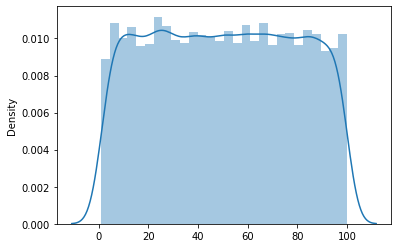

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


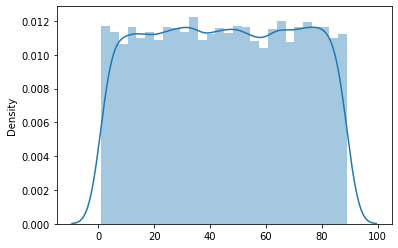

(20000, 2) 40000
(20000, 2) 40000


In [157]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
import math
import random
from datetime import datetime
import tensorboard
import seaborn as sns
%load_ext tensorboard
!rm -rf ./logs/

#Gernate Data
def data_generator():
    vel_data = np.random.uniform(1,100,size=20000)
    ang_data = np.random.uniform(1,89,size=20000)
    rad_data = np.radians(ang_data)
    H_data = (vel_data**2)*(np.sin(rad_data)**2)/(2*9.8)
    R_data = (vel_data**2)*(np.sin(rad_data*2))/9.8
    sns.distplot(vel_data, hist=True)
    plt.show()
    sns.distplot(ang_data, hist=True)
    plt.show()
    return vel_data, rad_data, H_data, R_data

def data_cleaning(data):
    return np.unique(data, axis=0)

vel_data, rad_data, H_data, R_data = data_generator()
train_data = {'Velocity': vel_data, 'Theta': rad_data, 'Height': H_data, 'Range': R_data}
X = np.stack((vel_data,rad_data),axis = 1)
#print("Ini X: ", X)
print(X.shape, X.size)
#X = data_cleaning(X)
#np.random.shuffle(X)
#print("New X: ", X)
#print(X.shape, X.size)
Y = np.stack((H_data,R_data),axis = 1)
#print("Ini Y: ", Y)
print(Y.shape, Y.size)
#Y = data_cleaning(Y)
#np.random.shuffle(Y)
#print("New Y: ", Y)
#print(Y.shape, Y.size)

In [158]:
#Build Model
epochs = 150
model = Sequential([
Dense(128, activation = 'relu', input_shape=(2, )),
Dense(64, activation = 'relu'),
Dense(64, activation = 'relu'),
Dense(32, activation = 'relu'),
Dense(2, activation = 'relu')])
model.compile(loss='mae', optimizer= Adam(learning_rate = 0.03/epochs), metrics= ['accuracy']) 
print(model.summary())
#logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

#Training with cross-validation (K-Fold)
k = 10
kf = KFold(n_splits = k, shuffle = True, random_state = 42)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index,:], X[test_index,:]
    Y_train, Y_test = Y[train_index,:], Y[test_index,:]
    X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.2)
    #Normalization
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)  
    results = model.fit(X_train,Y_train,batch_size=2048,
                        epochs=epochs,validation_data=(X_val,Y_val), 
                        )   #callbacks=[tensorboard_callback]
    #preds = model.predict(X_test)


Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_115 (Dense)            (None, 128)               384       
_________________________________________________________________
dense_116 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_117 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_118 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_119 (Dense)            (None, 2)                 66        
Total params: 14,946
Trainable params: 14,946
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
9/9 [==============================] - 1s 34ms/step - loss: 154.2154 - accuracy: 0.8516 - val_loss

In [159]:
#%tensorboard --logdir logs

In [160]:
'''
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
print("\n")

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)
'''
for i in range(5):
    vel = np.random.uniform(1,100)
    ang = np.random.uniform(1,89)
    rad = np.radians(ang)
    temp = [[vel, rad]]
    temp = np.asarray(temp)
    temp = scaler.transform(temp)
    preds = model.predict(temp)
    H = (vel**2)*(np.sin(rad)**2)/(2*9.8)
    R = (vel**2)*(np.sin(rad*2))/9.8
    print("Original: ", H, R)
    print("Predicted: ", preds)

Original:  0.05283815916537588 4.168867949757322
Predicted:  [[0.       4.392787]]
Original:  103.19471413611672 698.3316134336537
Predicted:  [[103.58029 698.94476]]
Original:  38.557796096203404 134.77595788903986
Predicted:  [[ 38.377975 135.2433  ]]
Original:  2.5064329305212594 76.03853633983294
Predicted:  [[ 2.1703618 75.92692  ]]
Original:  3.7865981075680515 27.41616487626097
Predicted:  [[ 3.639245 27.880793]]


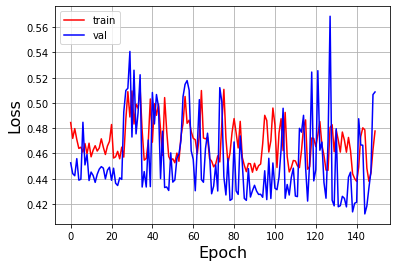

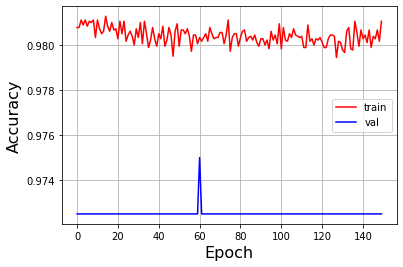

In [161]:
#Lauch the Graph
fig = plt.figure()
plt.plot(results.history['loss'], 'r', label='train')
plt.plot(results.history['val_loss'], 'b', label='val')
plt.xlabel(r'Epoch', fontsize=16)
plt.ylabel(r'Loss', fontsize=16)
plt.grid(True)
plt.legend()
plt.show()
fig.savefig('Loss.png')
plt.close()
fig = plt.figure()
plt.plot(results.history['accuracy'], 'r', label='train')
plt.plot(results.history['val_accuracy'], 'b', label='val')
plt.xlabel(r'Epoch', fontsize=16)
plt.ylabel(r'Accuracy', fontsize=16)
plt.grid(True)
plt.legend()
plt.show()
fig.savefig('Accuracy.png')
plt.close()

In [162]:
'''
#Compare original and predicted data
Velocity = []
Angle = []
Height = []
pre_Height = []
Range = []
pre_Range = []
for i in range(1000):
    #vel = np.random.uniform(1,100).astype(np.float32)
    vel = 50
    ang = np.random.uniform(1,89)
    Angle.append(ang)
    Velocity.append(vel)    
    rad = np.radians(ang)
    temp = [[vel, rad]]
    temp = np.asarray(temp)
    temp = scaler.transform(temp)
    preds = model.predict(temp)
    #fig = preds.tolist()
    #print(preds)
    pre_Height.append(preds[0][0])
    #print(pre_Height)
    pre_Range.append(preds[0][1])
    #print(pre_Range)
    H = (vel**2)*(np.sin(rad)**2)/(2*9.8)
    R = (vel**2)*(np.sin(rad*2))/9.8
    Height.append(H)
    Range.append(R) 

fig = plt.figure()
plt.plot(Angle, Height, 'bo', label='Original Data')
plt.plot(Angle, pre_Height, 'ro', label='Predicted Data')
plt.xlabel(r'Angle', fontsize=16)
plt.xticks([0,15,30,45,60,75,90])
plt.ylabel(r'Height', fontsize=16)
plt.grid(True)
plt.legend()
plt.show()
fig.savefig('Angle-Height.png')
plt.clf()
fig = plt.figure()
plt.plot(Angle, Range, 'bo', label='Original Data')
plt.plot(Angle, pre_Range, 'ro', label='Predicted Data')
plt.xlabel(r'Angle', fontsize=16)
plt.xticks([0,15,30,45,60,75,90])
plt.ylabel(r'Range', fontsize=16)
plt.grid(True)
plt.legend()
plt.show()
fig.savefig('Angle-Range.png')
plt.clf()
'''

"\n#Compare original and predicted data\nVelocity = []\nAngle = []\nHeight = []\npre_Height = []\nRange = []\npre_Range = []\nfor i in range(1000):\n    #vel = np.random.uniform(1,100).astype(np.float32)\n    vel = 50\n    ang = np.random.uniform(1,89)\n    Angle.append(ang)\n    Velocity.append(vel)    \n    rad = np.radians(ang)\n    temp = [[vel, rad]]\n    temp = np.asarray(temp)\n    temp = scaler.transform(temp)\n    preds = model.predict(temp)\n    #fig = preds.tolist()\n    #print(preds)\n    pre_Height.append(preds[0][0])\n    #print(pre_Height)\n    pre_Range.append(preds[0][1])\n    #print(pre_Range)\n    H = (vel**2)*(np.sin(rad)**2)/(2*9.8)\n    R = (vel**2)*(np.sin(rad*2))/9.8\n    Height.append(H)\n    Range.append(R) \n\nfig = plt.figure()\nplt.plot(Angle, Height, 'bo', label='Original Data')\nplt.plot(Angle, pre_Height, 'ro', label='Predicted Data')\nplt.xlabel(r'Angle', fontsize=16)\nplt.xticks([0,15,30,45,60,75,90])\nplt.ylabel(r'Height', fontsize=16)\nplt.grid(True)

In [163]:
'''
#Compare original and predicted data -- velocity
Velocity = []
Angle = []
Height = []
pre_Height = []
Range = []
pre_Range = []
for i in range(1000):
    vel = np.random.uniform(1,100)
    #vel = 50
    #ang = np.random.uniform(1,89)
    ang = 45
    Angle.append(ang)
    Velocity.append(vel)    
    rad = np.radians(ang)
    temp = [[vel, rad]]
    temp = np.asarray(temp)
    temp = scaler.transform(temp)
    preds = model.predict(temp)
    #fig = preds.tolist()
    #print(preds)
    pre_Height.append(preds[0][0])
    #print(pre_Height)
    pre_Range.append(preds[0][1])
    #print(pre_Range)
    H = (vel**2)*(np.sin(rad)**2)/(2*9.8)
    R = (vel**2)*(np.sin(rad*2))/9.8
    Height.append(H)
    Range.append(R) 

fig = plt.figure()
plt.plot(Velocity, Height, 'bo', label='Original Data')
plt.plot(Velocity, pre_Height, 'ro', label='Predicted Data')
plt.xlabel(r'Velocity', fontsize=16)
plt.xticks([0,20,40,60,80,100])
plt.ylabel(r'Height', fontsize=16)
plt.grid(True)
plt.legend()
plt.show()
fig.savefig('Velocity-Height.png')
plt.clf()
fig = plt.figure()
plt.plot(Velocity, Range, 'bo', label='Original Data')
plt.plot(Velocity, pre_Range, 'ro', label='Predicted Data')
plt.xlabel(r'Velocity', fontsize=16)
plt.xticks([0,20,40,60,80,100])
plt.ylabel(r'Range', fontsize=16)
plt.grid(True)
plt.legend()
plt.show()
fig.savefig('Velocity-Range.png')
plt.clf()
'''

"\n#Compare original and predicted data -- velocity\nVelocity = []\nAngle = []\nHeight = []\npre_Height = []\nRange = []\npre_Range = []\nfor i in range(1000):\n    vel = np.random.uniform(1,100)\n    #vel = 50\n    #ang = np.random.uniform(1,89)\n    ang = 45\n    Angle.append(ang)\n    Velocity.append(vel)    \n    rad = np.radians(ang)\n    temp = [[vel, rad]]\n    temp = np.asarray(temp)\n    temp = scaler.transform(temp)\n    preds = model.predict(temp)\n    #fig = preds.tolist()\n    #print(preds)\n    pre_Height.append(preds[0][0])\n    #print(pre_Height)\n    pre_Range.append(preds[0][1])\n    #print(pre_Range)\n    H = (vel**2)*(np.sin(rad)**2)/(2*9.8)\n    R = (vel**2)*(np.sin(rad*2))/9.8\n    Height.append(H)\n    Range.append(R) \n\nfig = plt.figure()\nplt.plot(Velocity, Height, 'bo', label='Original Data')\nplt.plot(Velocity, pre_Height, 'ro', label='Predicted Data')\nplt.xlabel(r'Velocity', fontsize=16)\nplt.xticks([0,20,40,60,80,100])\nplt.ylabel(r'Height', fontsize=16)\